In [1]:
import re
import os
import pickle
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression  # Baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, make_scorer, \
                            plot_roc_curve, roc_auc_score, roc_curve, auc, plot_confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp

%matplotlib inline

In [2]:
def save_as_pickle(f, fn):
    pth = os.path.join(os.getcwd(), 'Dataset', fn+'.pk')
    with open(pth, 'wb') as p:
        pickle.dump(f, p)

def load_from_pickle(fn):
    pth = os.path.join(os.getcwd(),  'Dataset', fn + '.pk')
    with open(pth, 'rb') as p:
        return pickle.load(p)

def load_pd_pickle(fn):
    pth = os.path.join(os.getcwd(), 'Dataset', fn + '.pk')
    return pd.read_pickle(pth)

In [3]:
y = load_from_pickle('y_classification')
cols_classification = load_from_pickle('y_cols_classification_005')
# cols_classification = load_from_pickle('cols_pearson')
X = load_pd_pickle('X')
X = X[cols_classification]

In [4]:
X.shape

(3648, 127)

In [5]:
# SMOTE
def use_smote(X, y):
#     sm = SMOTE(random_state = 42)
    sm = BorderlineSMOTE(random_state = 42)
    X_, y_ = sm.fit_resample(X, y)
    X_ = pd.DataFrame(X_, columns=X.columns)
    return X_, y_


# def balance_all_data(X, y):
    
#     # Oversampling
#     sm = SMOTE(random_state = 42)
#     X, y = sm.fit_resample(X, y)
#     X = pd.DataFrame(X, columns=X.columns)
#     # Create training and test data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
#     return X_train.reset_index().drop(['index'], axis=1), X_test.reset_index().drop(['index'], axis=1), y_train, y_test

# def balance_training_data(X, y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
#     print("Training set before SMOTE has {} samples.".format(X_train.shape[0]))    
#     # Oversampling
#     sm = SMOTE(random_state = 42)
#     X_train, y_train = sm.fit_resample(X_train, y_train)
#     # Create training and test data
#     X_train = pd.DataFrame(X_train, columns=X.columns)
#     return X_train.reset_index().drop(['index'], axis=1), X_test.reset_index().drop(['index'], axis=1), y_train, y_test

# # sm = SMOTE(random_state = 42)
# # X, y = sm.fit_resample(X, y)

# # get column names
# cols = X.columns.to_list()
# # Training and test sets
# X_train, X_test, y_train, y_test = balance_all_data(X, y)
# print("Training set has {} samples.".format(X_train.shape[0]))
# print("Testing set has {} samples.".format(X_test.shape[0]))



In [6]:
Counter(y)

Counter({1: 981, 0: 2667})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train = X_train.reset_index().drop(['index'], axis=1)
X_test = X_test.reset_index().drop(['index'], axis=1)

In [8]:
def get_models():

    return [
                # ExtraTreesClassifier(),
                RandomForestClassifier(random_state = 0),
                SVC(kernel='linear', probability=True),
                XGBClassifier(),
                # SGDClassifier(random_state = 0), 
                KNeighborsClassifier(),
                LogisticRegression()
             ]
    
def train_models(X, y, n_splits):

    models = get_models()
    
    results_accuracy = {}
    results_precision = {}
    results_recall = {}
    results_f1 = {}
    results_roc = {}
    for model in models:
        name = str(model).split("(")[0]
        results_accuracy[name] = []
        results_precision[name] = []
        results_recall[name] = []
        results_f1[name] = []
        results_roc[name] = []
        
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for i, (t, v) in enumerate(cv.split(X, y)):
        
        X_train = X.loc[t]
        y_train = y[t]
        X_valid = X.loc[v]
        y_valid = y[v]
        
        for model in models:
            name = str(model).split("(")[0]
#             print('{} Starts.'.format(name))
            
            # Instantiate and fit Classification Model
            clf_model = model
            clf_model.fit(X_train, y_train)

            # Make predictions with model
            y_pred = clf_model.predict(X_valid)

            # precision_score, recall_score, accuracy_score, f1_score
            # Grab model name and store results associated with model

            results_accuracy[name].append(accuracy_score(y_valid, y_pred))
            results_precision[name].append(precision_score(y_valid, y_pred, average='macro'))
            results_recall[name].append(recall_score(y_valid, y_pred, average='macro'))
            results_f1[name].append(f1_score(y_valid, y_pred, average='macro'))
            results_roc[name].append(roc_auc_score(y_valid, clf_model.predict_proba(X_valid)[:, 1], average='macro'))
#             print('{} done.'.format(name))
    
    return  results_accuracy, results_precision, results_recall, results_f1, results_roc

def results(r):
    cols = ['Model', 'Accuracy Mean', 'Accuracy SD', 
            'Precision Mean', 'Precision SD', 
            'Recall Mean', 'Recall SD', 
            'F1 Mean', 'F1 SD', 
            'AUC Mean', 'AUC SD']   
    df = pd.DataFrame(columns = cols)
    models = get_models()
    for model in models:
        name = str(model).split("(")[0]
        row = {}
        row[cols[0]] = name
        for i, score in enumerate(r):
            s = np.array(score[name]).mean()
            st = np.array(score[name]).std()
            row[cols[2*i+1]] = str(round(s, 4))
            row[cols[2*i+2]] = str(round(st, 4))
        df = df.append(row, ignore_index = True)
    return df

In [ ]:
a = train_models(X_train, y_train, 10)

In [10]:
results(a)

,Model,Accuracy Mean,Accuracy SD,Precision Mean,Precision SD,Recall Mean,Recall SD,F1 Mean,F1 SD,AUC Mean,AUC SD
0,RandomForestClassifier,0.7879,0.0172,0.7537,0.0355,0.6442,0.031,0.6618,0.036,0.81,0.0194
1,SVC,0.7745,0.0208,0.7127,0.0381,0.6513,0.0347,0.6648,0.0415,0.7904,0.0276
2,XGBClassifier,0.7738,0.0168,0.7113,0.0265,0.6608,0.0225,0.6742,0.0237,0.7894,0.0167
3,KNeighborsClassifier,0.7536,0.0236,0.6738,0.0543,0.6002,0.0364,0.6075,0.0451,0.7027,0.0367
4,LogisticRegression,0.78,0.0196,0.7201,0.0319,0.672,0.0274,0.6858,0.0297,0.7955,0.0238


In [12]:
X_train_smote, y_train_smote = use_smote(X_train, y_train)

# default paras

In [18]:
model = RandomForestClassifier()
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

In [19]:
accuracy_score(y_test, y_pred)

0.7547945205479452

# fine tune

In [ ]:
criterion = ['gini', 'entropy']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random_rf = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, scoring='balanced_accuracy', cv=10, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
model_random_rf.fit(X_train_smote, y_train_smote)

In [52]:
best_random_rf = model_random_rf.best_estimator_
y_pred = best_random_rf.predict(X_test)
accuracy_score(y_test, y_pred)


0.7726027397260274

In [53]:
f1_score(y_test, y_pred, average='macro')
# roc_auc_score(y_test, best_random.predict_proba(X_test)[:, 1])

0.7047270955165692

In [54]:
precision_score(y_test, y_pred, average='macro')

0.7216311500277228

In [55]:
recall_score(y_test, y_pred, average='macro')

0.6945605157545758

Confusion matrixn
[[457  64]
 [102 107]]
Normalized confusion matrix (%)
[[0.88 0.12]
 [0.49 0.51]]


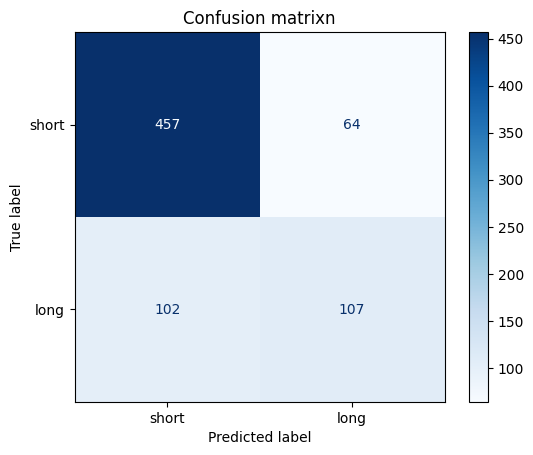

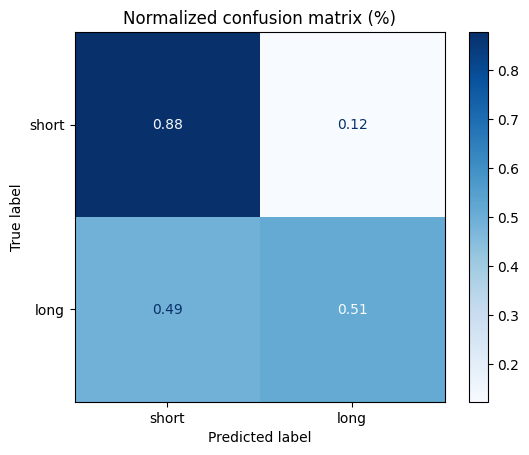

In [56]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrixn", None),
                  ("Normalized confusion matrix (%)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_random_rf, X_test, y_test, display_labels=['short', 'long'], 
                          cmap=plt.cm.Blues, normalize=normalize)  
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

# Feature selection


In [31]:
features_names = X.columns

In [37]:
importance = best_random_rf.feature_importances_
a, b = zip(*sorted(list(zip(importance, features_names))))
df = pd.DataFrame(b)
df_import_features = pd.DataFrame()
df_sorted = pd.DataFrame()
#df.columns=['imp','feature']
df['a'] = a
df.columns=['feature','imp']
df_sorted = df.sort_values(by=['imp'], ascending=False).copy()
df_import_features = df_sorted.iloc[0:20,:]
df_import_features

,feature,imp
126,lab_PHOSPHORUS,0.058527
125,lab_MAGNESIUM,0.050332
124,lab_INTERNATIONAL NORMALIZED RATIO,0.049574
123,age_at_visit_years,0.020905
122,lab_GLUCOSE POC,0.017917
121,lab_ALBUMIN,0.017620
120,lab_IMMATURE GRANULOCYTE %,0.016727
119,lab_LACTATE DEHYDROGENASE,0.015427
118,lab_CO2 ARTERIAL,0.014604
117,lab_LACTIC ACID,0.014411


In [43]:
f = df_import_features['feature']
imp = df_import_features['imp']
l = f.to_list()
l = [i.replace('lab_', '').replace('med_', '').replace('_', ' ') for i in l]
l

['PHOSPHORUS',
 'MAGNESIUM',
 'INTERNATIONAL NORMALIZED RATIO',
 'age at visit years',
 'GLUCOSE POC',
 'ALBUMIN',
 'IMMATURE GRANULOCYTE %',
 'LACTATE DEHYDROGENASE',
 'CO2 ARTERIAL',
 'LACTIC ACID',
 'GLUCOSE',
 'BLOOD UREA NITROGEN',
 'CREATININE',
 'RED CELL DISTRIBUTION WIDTH',
 'WHITE BLOOD CELL COUNT',
 'LYMPH PERCENT',
 'HEMATOCRIT',
 'PLATELET COUNT',
 'MONOCYTE ABSOLUTE',
 'MEAN PLATELET VOLUME']

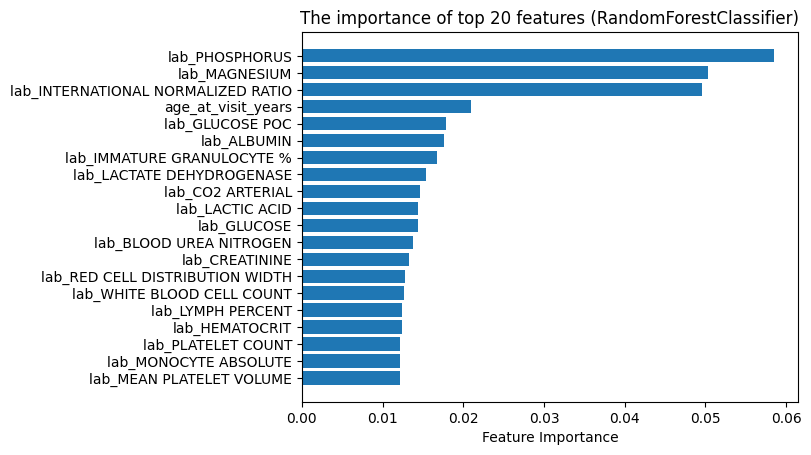

In [46]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(f))
ax.barh(y_pos, imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(f)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('The importance of top 20 features (RandomForestClassifier)')

plt.show()

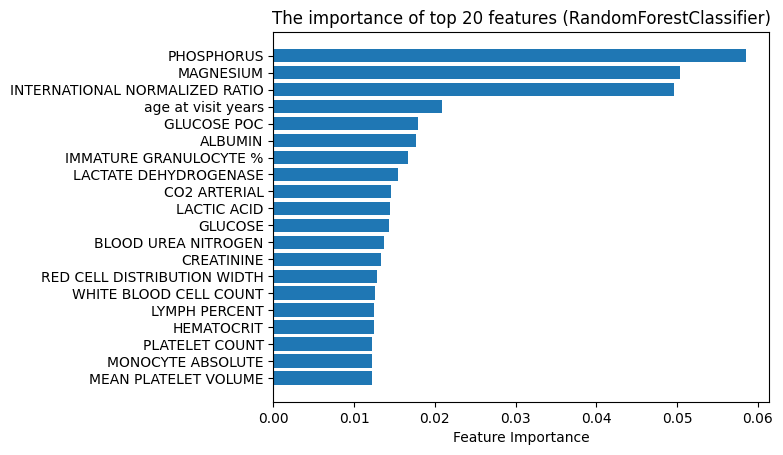

In [47]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(f))
ax.barh(y_pos, imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(l)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('The importance of top 20 features (RandomForestClassifier)')

plt.show()

# AUC

In [57]:
y_score = best_random_rf.predict_proba(X_test)
pos_probs = y_score[:, 1]
fpr, tpr, _ = roc_curve(y_test, pos_probs)
roc_score = roc_auc_score(y_test, pos_probs, average='macro')

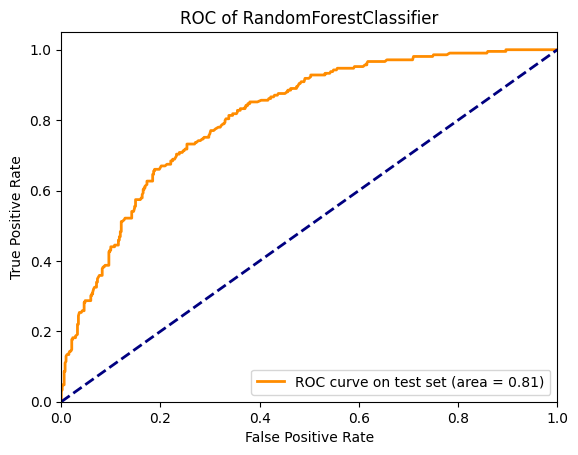

In [58]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve on test set (area = %0.2f)' % roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()